In [248]:
import pandas as pd
pd.set_option("display.max_rows", 150)
pd.set_option('display.max_colwidth', -1)

import numpy as np

import glob

import gpxpy
import gpxpy.gpx

import re

from IPython.display import SVG,display, HTML

import requests
import pickle

from sklearn.neighbors import KDTree

In [569]:
# functions for judging a description
not_flowing_keywords = ["dry", "no water", "no flow"]
def isNotFlowing(description):
    return any([kw in description for kw in not_flowing_keywords])
assert(isNotFlowing("looks dry"))

flowing_keywords = ["good", "flowing", "flow", "lots", "working", "liter", "plenty"]
def isFlowing(description):
    return any([kw in description for kw in flowing_keywords])
assert(isFlowing("flowing well"))


tank_keywords = ["tank", "cache"]
def isTank(description):
    return any([kw in description for kw in tank_keywords])
assert(isTank("tank empty"))

In [570]:
# a function that tries to fix a location id, leaves non-waypoint labels alone in case they are in the gps data
# fixes the leading zeros problem WR004 = WR0004
def clean_loc_id(id):
    try:
        waypoint_search = re.search('((?:WR|WA)(?:CS|))([0-9]+)', id, re.IGNORECASE)

        if waypoint_search:        
            waypoint_type = waypoint_search.group(1)
            waypoint_num = waypoint_search.group(2)

            return f"{waypoint_type}{int(waypoint_num):04}"
    except:
        return id
    return id
assert(clean_loc_id("WR004") == "WR0004")

In [482]:
# functions for finding the last positive result and last negative result
def last_pos(mile, date):
    last_pos_date = data[(data.mile == mile) & (data.status==1) & (data.date < date)].date.max()
    if type(last_pos_date) == float:
        return 2000
    return (date - last_pos_date).days
    
def last_neg(mile, date):
    last_neg_date = data[(data.mile == mile) & (data.status==0) & (data.date < date)].date.max()    
    if type(last_neg_date) == float:
        return 2000
    return (date - last_neg_date).days

In [483]:
# create a lat, lon, and name dictionaries keyed on loc_ids 
waypoints = []
for path in glob.glob("gps/*.gpx"):
    gpx_file = open(path, 'r')
    gpx = gpxpy.parse(gpx_file)
    waypoints += (gpx.waypoints)
    
lat = {clean_loc_id(wp.name):wp.latitude for wp in waypoints}
lon = {clean_loc_id(wp.name):wp.longitude for wp in waypoints}

In [549]:
# a generator for sequentially reading in the data
def data_generator():
    for f in glob.glob("pct_data/*.xlsx"):
        data = pd.read_excel(f).dropna()
        _,cols = data.shape
        if cols == 7:
            data.columns = ["map","mile","loc_id","name", "description", "date", "user"]
        if cols == 8:
            data.columns = ["map","mile_2","mile","loc_id","name", "description", "date", "user"]
        yield data

In [550]:
# import and combine tip line data
data_tip = pd.concat(data_generator())

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [551]:
data_gh=pd.read_csv("guthook_data/PCTWater-wpts-Comments.csv").rename(columns=
    {
        "Date":"date",
        "WptId":"loc_id",
        "WptName":"name",
        "Latitude":"lat",
        "Longitude":"lon",
        "Comment":"description",
        "PCT Mile": "mile"
    })

In [552]:
# clean up the guthook dates
data_gh.date = pd.to_datetime(data_gh.date)

In [553]:
# clean up the lod_ids in the tip line data
data_tip.loc_id = data_tip.loc_id.apply(clean_loc_id)

In [554]:
# create lat and lon columns
data_tip["lat"] = data_tip["loc_id"].map(lat)
data_tip["lon"] = data_tip["loc_id"].map(lon)

In [555]:
# merge the two mile fields in the tip lin data
data_tip.mile = data_tip.mile.fillna(data_tip.mile_2)

In [556]:
# drop data with missing coordinates
data_tip = data_tip.dropna(subset=["lat", "mile"])

In [557]:
data = pd.concat([data_tip, data_gh])

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [558]:
# clean up the descriptions
data.description = data.description.str.split("\n").str[0].str.lower()

In [559]:
# create a unix time column
data["unix_time"] = (pd.to_datetime(data["date"], errors='coerce').astype(np.int64)//1000000000)

In [571]:
# create not_flowing and flowing columns
data["not_flowing"] = data["description"].map(isNotFlowing, na_action="ignore")
data["flowing"] = data["description"].map(isFlowing, na_action="ignore")
data["tank"] = data["description"].map(isTank, na_action="ignore")
data["decision"] = (data.flowing^data.not_flowing)&(~data.tank.astype(bool)) # logical xor
data["status"] = data.flowing.astype(float)

In [572]:
print(f"only one {(data.flowing^data.not_flowing).sum()}")
print(f"at least one {(data.flowing|data.not_flowing).sum()}")
print(f"both {(data.flowing&data.not_flowing).sum()}")
print(f"tank {data.tank.sum()}")


only one 43781
at least one 44859
both 1078
tank 1694


In [573]:
# remove all data with no decision
data = data[data.decision]

In [574]:
# remove duplicate entries (ones with the same date and loc_id)
data = data.drop_duplicates(subset=["date","mile"])

In [622]:
data['month'] = data.date.map(lambda d:d.month)
data['DOY'] = data.date.dt.dayofyear
data['sinDOY'] = np.sin(2  * np.pi * data.date.dt.dayofyear/365.)
data['cosDOY'] = np.cos(2  * np.pi * data.date.dt.dayofyear/365.)

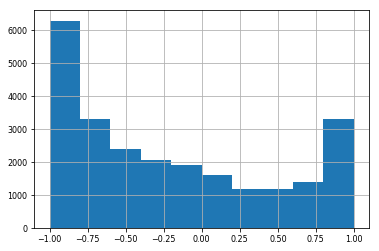

In [576]:
data.sinDOY.hist()

In [577]:
miles = list(data.groupby("mile").nunique().sort_values(by="date")[-150:].loc_id.index)

In [578]:
data = data[data.mile.isin(miles)]

In [579]:
data.shape

(8629, 20)

In [645]:
# create last positive and negative result columns
data["last_pos"] = data.apply(lambda row: last_pos(row.mile, row.date), axis=1)
data["last_neg"] = data.apply(lambda row: last_neg(row.mile, row.date), axis=1)


In [650]:
data["last"] = data[['last_pos','last_neg']].min(axis=1)

In [653]:
last_avg_source = data.groupby("mile")["last"].mean()
data["last_avg"] = data.mile.map(lambda m: last_avg_source.get(m))
data["last_neg_rel"] = data.last_neg / data.last_avg
data["last_pos_rel"] = data.last_pos / data.last_avg


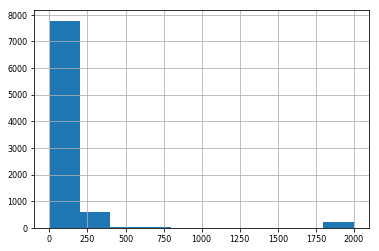

In [581]:
data.last_pos.hist()

In [582]:
data["prob_exp"] = data.apply(lambda row: data[row.mile == data.mile].status.mean(), axis=1)

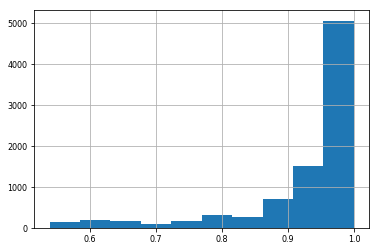

In [769]:
data.prob_exp.hist(bins=10)

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


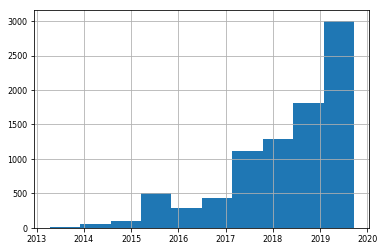

In [770]:
data.date.hist()

In [584]:
try:
    f = open('rain_memo_coords.pkl', 'rb')
    rain_memo = pickle.load(f)
    f.close()
except:
    print("no rain memo")
    rain_memo = {}

def getRainfall(lat, lon, unix_time):
    lat, lon = round(lat,2),round(lon,2)
    if (lat, lon, unix_time) in rain_memo:
        return rain_memo[(lat,lon, unix_time)]
    print(f"{lat},{lon},{unix_time} not found, calling DarkSky")
    r = requests.get(f"https://api.darksky.net/forecast/840fdc3fb61acc3d4e904978b5ba8dc5/{lat},{lon},{unix_time}?exclude=currently,minutely,hourly,alerts")
    
    try:
        rain = r.json()["daily"]["data"][0]["precipIntensity"]
        rain_memo[(lat, lon, unix_time)] = rain
    except:
        rain = 0
        print(f"Data parse error {lat},{lon},{unix_time}")
        
    f = open('rain_memo_coords.pkl', 'wb')
    pickle.dump(rain_memo, f)
    f.close() 
    
    return rain

In [585]:
def getRainSum(lat, lon, unix_time, n):
    return 24 * sum([getRainfall(lat, lon, unix_time - (24*60*60*day)) for day in range(0,n)])

In [586]:
data["rain_5"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 5), axis=1)
data["rain_3"] = data.apply(lambda row: getRainSum(row.lat, row.lon, row.unix_time, 3), axis=1)

33.06,-116.53,1523664000 not found, calling DarkSky
33.05,-116.52,1551484800 not found, calling DarkSky
33.05,-116.52,1551398400 not found, calling DarkSky
33.05,-116.52,1551312000 not found, calling DarkSky
33.05,-116.52,1551225600 not found, calling DarkSky
33.05,-116.52,1551139200 not found, calling DarkSky
33.06,-116.53,1524787200 not found, calling DarkSky
33.06,-116.53,1524700800 not found, calling DarkSky
33.06,-116.53,1524614400 not found, calling DarkSky
33.06,-116.53,1524528000 not found, calling DarkSky
33.06,-116.53,1555200000 not found, calling DarkSky
40.05,-121.38,1411948800 not found, calling DarkSky
40.05,-121.38,1411862400 not found, calling DarkSky
40.05,-121.38,1411776000 not found, calling DarkSky
40.05,-121.38,1411689600 not found, calling DarkSky
40.05,-121.38,1411603200 not found, calling DarkSky
40.05,-121.38,1434844800 not found, calling DarkSky
40.05,-121.38,1434758400 not found, calling DarkSky
40.05,-121.38,1434672000 not found, calling DarkSky
40.05,-121.3

In [591]:
rain_5_avg_source = data.groupby("mile").rain_5.mean()
data["rain_5_avg"] = data.mile.map(lambda m: rain_5_avg_source.get(m))
data["rain_5_rel"] = data.rain_5 / data.rain_5_avg

In [592]:
rain_3_avg_source = data.groupby("mile").rain_3.mean()
data["rain_3_avg"] = data.mile.map(lambda m: rain_3_avg_source.get(m))
data["rain_3_rel"] = data.rain_3/ data.rain_3_avg

In [593]:
data[data.status==0].rain_5_rel.mean()

0.93118864744072638

In [594]:
data[data.status==1].rain_5_rel.mean()

1.0052898780951594

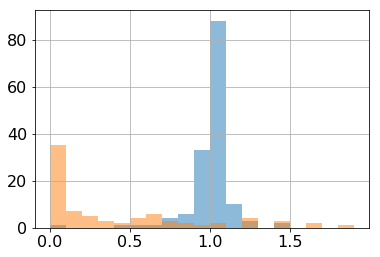

In [871]:

data[data.status==1].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,2,.1), alpha=0.5)

data[data.status==0].groupby("mile").rain_5_rel.mean().hist(bins=np.arange(0,2,.1), alpha=0.5)

In [596]:
gw = pd.read_csv("ground_water/gwlevels", sep="\t")

In [597]:
def dms2lat(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[0:2], dms[2:4], dms[4:6]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return dd;

def dms2lon(dms):
    dms = str(dms)
    degrees, minutes, seconds = dms[6:9], dms[9:11], dms[11:13]
    #print(degrees)
    dd = float(degrees) + float(minutes)/60 + float(seconds)/(60*60);
    return -dd;

In [598]:
gw["lat"] = gw.site_no.map(dms2lat)
gw["lon"] = gw.site_no.map(dms2lon)

In [599]:
gw = gw[['lev_va', 'lev_dt', 'lat', 'lon', 'site_no']]
gw.columns=["meas", "date", "lat", "lon", 'site_id']

In [600]:
gw["unix_time"] = (pd.to_datetime(gw["date"], errors='coerce').astype(int)//1000000000)
gw["unix_time_reduced"] = gw["unix_time"]//10000000
data["unix_time_reduced"] = gw["unix_time"]//10000000
gw = gw.dropna()

In [601]:
kdt = KDTree(gw[['lat', 'lon', 'unix_time_reduced']])
dist, i = kdt.query(data[['lat', 'lon', 'unix_time_reduced']])

In [602]:
data['ground_water'] = gw.iloc[i.flatten()].meas.values

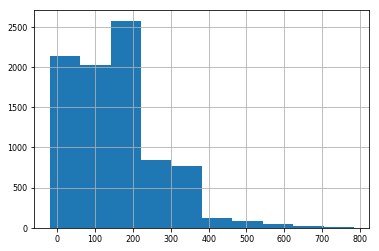

In [603]:
data.ground_water.hist()

In [604]:
data[["rain_3_rel","last_pos","last_neg","prob_exp", "month","ground_water","status"]].corr()

,rain_3_rel,last_pos,last_neg,prob_exp,month,ground_water,status
rain_3_rel,1.000000e+00,0.010560,-0.022266,-5.871315e-17,-0.053230,0.002120,0.008344
last_pos,1.056030e-02,1.000000,0.043713,-1.252176e-01,-0.092016,0.019416,-0.204169
last_neg,-2.226617e-02,0.043713,1.000000,6.118092e-01,0.251718,-0.099733,0.239373
prob_exp,-5.871315e-17,-0.125218,0.611809,1.000000e+00,0.340031,-0.120725,0.412597
month,-5.322955e-02,-0.092016,0.251718,3.400314e-01,1.000000,-0.204658,0.004655
ground_water,2.119710e-03,0.019416,-0.099733,-1.207248e-01,-0.204658,1.000000,-0.052607
status,8.344292e-03,-0.204169,0.239373,4.125968e-01,0.004655,-0.052607,1.000000


In [605]:
data[data.status==0].sample(10).description

8566     no miracles here, still dry.                                                                                                                                                                                                                   
15690    dry as a dodo                                                                                                                                                                                                                                  
569      dry.                                                                                                                                                                                                                                           
20672    dry at the crossing. small trickle upstream.                                                                                                                                                                                                   
8107

In [738]:
def last_result(row):
    try:
        return data[(data.mile==row.mile)&(data.date < row.date)].sort_values("date", ascending=False).status.values[0]
    except:
        return 0

In [739]:
data["last_result"] = data.apply(last_result, axis=1)

In [734]:
data

,Elevation(m),date,description,lat,loc_id,lon,map,mile,mile_2,name,...,rain_5_rel,rain_3_avg,rain_3_rel,unix_time_reduced,ground_water,cosDOY,last,last_avg,last_neg_rel,last_pos_rel
10,NaN,2018-02-17 00:00:00,flowing pretty good.,32.608000,WR0004,-116.498991,A1,4.4,NaN,Creeklet [early spring only]\nBeware of poison oak here.,...,0.301257,0.123421,0.233347,138,316.83,0.677615,2,27.588652,15.586118,0.072494
13,NaN,2018-01-30 00:00:00,dry,32.661418,WRCS0015,-116.545505,A2,15.4,NaN,Hauser Creek [early spring only],...,0.000000,0.150877,0.000000,140,273.34,0.869589,6,35.115385,0.170865,6.720701
17,NaN,2018-02-03 00:00:00,dry,32.715239,WR0024,-116.499008,A3,24.1,NaN,Cottonwood Creek Bridge,...,0.000000,0.207847,0.000000,142,327.55,0.833556,24,49.041096,0.489385,5.158939
18,NaN,2018-02-03 00:00:00,2/3/18 (warner springs monty) : flowing. crossed on a log.,32.729263,WR0026,-116.490416,A3,25.5,NaN,Cottonwood Creekbed,...,0.000000,0.177500,0.000000,143,197.60,0.833556,6,59.097222,7.039248,0.101528
27,NaN,2018-02-03 00:00:00,2/3/18 (warner springs monty) : dry.,32.764221,WRCS0032,-116.439089,A4,32,NaN,Fred Canyon [usually dry],...,0.000000,0.083034,0.000000,135,327.06,0.833556,6,44.329268,0.135351,5.346355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31908,1641.1,2019-08-23 00:00:00,nothing flowing but there is a small pool of water if desperate,47.457120,SKYnewstream001,-121.299870,NaN,2407.6,NaN,Stream,...,0.988879,0.075385,1.782857,141,6.62,-0.618671,16,89.589744,0.212078,0.178592
31909,1641.1,2019-08-25 00:00:00,dry here\r,47.457120,SKYnewstream001,-121.299870,NaN,2407.6,NaN,Stream,...,1.058274,0.075385,0.254694,141,6.62,-0.591261,2,89.589744,0.234402,0.022324
31914,1641.1,2019-09-11 00:00:00,moderate flow after the rains 🤤,47.457120,SKYnewstream001,-121.299870,NaN,2407.6,NaN,Stream,...,6.332295,0.075385,9.901224,142,7.07,-0.333469,17,89.589744,0.189754,0.212078
31915,1641.1,2019-09-13 00:00:00,"lots of flow, but it rained today",47.457120,SKYnewstream001,-121.299870,NaN,2407.6,NaN,Stream,...,5.620996,0.075385,1.655510,143,5.21,-0.300820,2,89.589744,0.212078,0.022324


In [750]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, BayesianRidge
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC

from graphviz import Source

from sklearn.dummy import DummyClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report, precision_recall_curve


from sklearn.model_selection import train_test_split

import time

from matplotlib import cm
from scipy import interpolate

import matplotlib.pyplot as plt

In [607]:
data[data.status == 1].shape[0]

8013

(16026,) (10772,) (2673,) (2522,)
tree
              precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      1162
         1.0       0.90      0.88      0.89      1511

    accuracy                           0.87      2673
   macro avg       0.87      0.87      0.87      2673
weighted avg       0.87      0.87      0.87      2673

0.895875591616
tree
              precision    recall  f1-score   support

         0.0       1.00      0.07      0.13      1162
         1.0       0.58      1.00      0.74      1511

    accuracy                           0.60      2673
   macro avg       0.79      0.54      0.43      2673
weighted avg       0.76      0.60      0.47      2673

0.970766129032
dummy
              precision    recall  f1-score   support

         0.0       0.43      1.00      0.61      1162
         1.0       0.00      0.00      0.00      1511

    accuracy                           0.43      2673
   macro avg       0.22      0.50      0.30     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(-0.05, 1.05)

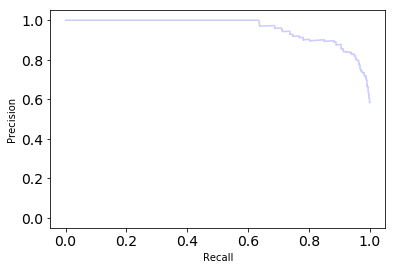

In [781]:
data_neg_over = data[data.status == 0].sample(data[data.status == 1].shape[0], replace=True)
data_over = pd.concat([data[data.status == 1], data_neg_over], axis=0)

#data_over = data
data_over = data_over.dropna(subset=['ground_water'])

inputs = data_over[["rain_3_rel","rain_5_rel","last_pos_rel","last_neg_rel", "prob_exp", "sinDOY", "cosDOY","ground_water"]]
labels = data_over["status"]

X_train = inputs[data_over.mile%10. < 6]
y_train = labels[data_over.mile%10. < 6]
X_valid = inputs[(data_over.mile%10. > 6)&(data_over.mile%10. < 8)]
y_valid = labels[(data_over.mile%10. > 6)&(data_over.mile%10. < 8)]
X_test = inputs[data_over.mile%10. > 8]
y_test = labels[data_over.mile%10. > 8]
print(labels.shape, y_train.shape, y_valid.shape, y_test.shape)

#X_train, X_valid, y_train, y_valid = train_test_split(inputs, labels, random_state=0)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=0)
#X_train, X_test, y_train, y_test = inputs[data.loc_id != "WR0004"], inputs[data.loc_id == "WR0004"],labels[data.loc_id != "WR0004"],labels[data.loc_id == "WR0004"]
#X_train, X_test, y_train, y_test = train_test_split(inputs, labels, random_state=0, stratify=data.loc_id)

#display(X_test.groupby("loc_id").count())
#display(X_train.groupby("loc_id").count())
#dt = LogisticRegression().fit(X_train, y_train)
#dt = SVC(probability=True).fit(X_train, y_train)
#br = BayesianRidge().fit(X_train, y_train)
#dt = RandomForestClassifier(max_depth = 5).fit(X_train, y_train)
dt = AdaBoostClassifier().fit(X_train, y_train)
#dt = DecisionTreeClassifier(max_depth = 7, criterion='entropy').fit(X_train, y_train)

dummy = DummyClassifier().fit(X_train, y_train)
dummy_majority = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)

#print(f'Training score {lr.score(X_train, y_train)}')
#print(f'Training score {svc.score(X_train, y_train)}')
#print(f'Training score {rf.score(X_train, y_train)}')

#print('random forest')
#print(classification_report(y_test, rf.predict(X_test)))

dt_cal = CalibratedClassifierCV(dt, cv='prefit').fit(X_train, y_train)
dummy_cal = CalibratedClassifierCV(dummy, cv='prefit').fit(X_train, y_train)
dummy_majority_cal = CalibratedClassifierCV(dummy_majority, cv='prefit').fit(X_train, y_train)


print('tree')
print(classification_report(y_valid, dt_cal.predict(X_valid)))
print(y_valid[dt_cal.predict_proba(X_valid)[:, 1] > 0.5].mean())

print('tree')
print(classification_report(y_valid, dt_cal.predict_proba(X_valid)[:, 1] > 0.05))
print(y_valid[dt_cal.predict_proba(X_valid)[:, 1] > 0.8].mean())

print('dummy')
print(classification_report(y_valid, dummy_cal.predict(X_valid)))

print('most frequent')
print(classification_report(y_valid, dummy_majority_cal.predict(X_valid)))

#print('last')
#print(classification_report(y_valid, X_valid.last_result))

precision, recall, thresh = precision_recall_curve(y_valid, dt_cal.predict_proba(X_valid)[:,1])

thresh_95 = min([t for (p, t) in zip(precision, thresh) if p > 0.95])
thresh_50 = min([t for (p, t) in zip(precision, thresh) if p > 0.5])
print(thresh_95)
print(thresh_50)

for p, t in zip(precision, thresh):
    if p > 0.5:
        print (p,t)
        break


plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

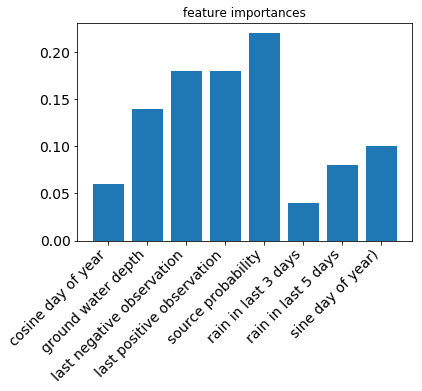

In [780]:
imp = dt.feature_importances_


plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 
fig = plt.figure()
ax = fig.add_subplot(111)
plt.title("feature importances")
ax.bar(X_test.columns, imp)
ax.set_xticklabels( ["cosine day of year", "ground water depth", "last negative observation","last positive observation",  "source probability", "rain in last 3 days",  "rain in last 5 days", "sine day of year)"], rotation=45 , ha="right")
plt.show()

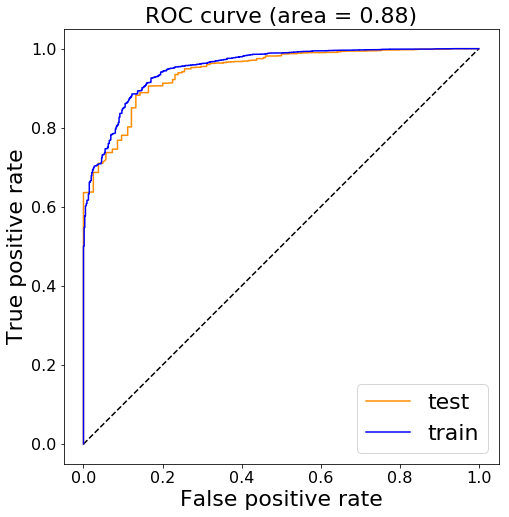

In [862]:

fig = plt.figure(figsize=(8, 8))

ax = fig.add_subplot(111)

ax.plot([0, 1], [0, 1], 'k--')

plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16) 

ax.set_aspect(aspect=1)
y_probs = dt.predict_proba(X_valid)[:, 1]
y_predicted = dt.predict(X_valid)
auc = roc_auc_score(y_valid, y_predicted)
false_positive, true_positive, _  = roc_curve(y_valid, y_probs)
ax.plot(false_positive, true_positive, color='darkorange', label='test')


y_probs = dt.predict_proba(X_train)[:, 1]
y_predicted = dt.predict(X_train)
auc = roc_auc_score(y_train, y_predicted)
false_positive, true_positive, _  = roc_curve(y_train, y_probs)
ax.plot(false_positive, true_positive, color='blue', label='train')
ax.legend(fontsize=22)

plt.xlabel('False positive rate', fontsize=22)
plt.ylabel('True positive rate', fontsize=22)
plt.title('ROC curve (area = %0.2f)' % auc, fontsize=22)
plt.show()

In [708]:
out = []
for mile in miles:
    now = pd.Timestamp.now().round('1d') 
    lat = data[data.mile==mile].lat.values[0]
    lon = data[data.mile==mile].lon.values[0]
    rain_3_avg = data[data.mile==mile].rain_3_avg.values[0]
    rain_5_avg = data[data.mile==mile].rain_5_avg.values[0]
    last_avg = data[data.mile==mile].last_avg.values[0]
    name = data[data.mile==mile].name.mode().values[0]
    
    ["rain_3_rel","rain_5_rel","last_pos_rel","last_neg_rel","prob_exp", "sinDOY", "cosDOY","ground_water"]
    
    result = {
        'lat': lat, 
        'lon': lon, 
        'name': name,
        'mile': mile
    }
    
    _, i = kdt.query([[lat, lon, (now.value // 10**16) ]])
    ground_water = gw.iloc[i.flatten()].meas.values[0]
    
    for days in range(4):
        prediction = dt_cal.predict_proba([[
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 3)/rain_3_avg, 
                    getRainSum(lat, lon, int(now.value/10**9) + (24*60*60*days), 5)/rain_5_avg, 
                    (last_pos(mile, now) + days)/last_avg, 
                    (last_neg(mile, now) + days)/last_avg,
                    data[mile == data.mile].status.mean(),
                    np.sin(2  * np.pi * now.dayofyear/365.),
                    np.cos(2  * np.pi * now.dayofyear/365.),
                    ground_water
                ]])
        result[f'prediction_{days}'] = prediction[0][1]
    
    out.append(result)

    
f = open('out_combined.pkl', 'wb')
pickle.dump(out, f)
f.close() 

[[ 0.90414539  0.09585461]]
[[ 0.90414539  0.09585461]]
[[ 0.92922806  0.07077194]]
[[ 0.91517323  0.08482677]]
[[ 0.67209646  0.32790354]]
[[ 0.67209646  0.32790354]]
[[ 0.67209646  0.32790354]]
[[ 0.67209646  0.32790354]]
[[ 0.60754689  0.39245311]]
[[ 0.50671613  0.49328387]]
[[ 0.34668323  0.65331677]]
[[ 0.34668323  0.65331677]]
[[  3.33735262e-11   1.00000000e+00]]
[[  3.82955889e-11   1.00000000e+00]]
[[  9.41202671e-12   1.00000000e+00]]
[[  2.84756663e-11   1.00000000e+00]]
[[ 0.78390676  0.21609324]]
[[ 0.83637901  0.16362099]]
[[ 0.78390676  0.21609324]]
[[ 0.81381353  0.18618647]]
[[  1.00519371e-10   1.00000000e+00]]
[[  1.00519371e-10   1.00000000e+00]]
[[  4.15163459e-11   1.00000000e+00]]
[[  4.15163459e-11   1.00000000e+00]]
[[  5.50950396e-11   1.00000000e+00]]
[[  5.50950396e-11   1.00000000e+00]]
[[  5.50950396e-11   1.00000000e+00]]
[[  2.28601582e-11   1.00000000e+00]]
[[ 0.51351988  0.48648012]]
[[ 0.47689973  0.52310027]]
[[ 0.90976329  0.09023671]]
[[ 0.9097632

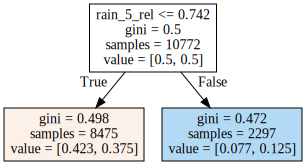

In [819]:
graph = Source( export_graphviz(dt.estimators_[11], out_file=None, feature_names=X_test.columns, filled=True))


SVG(graph.pipe(format='svg'))

In [841]:
data.groupby("mile").count().sort_values(by="date", ascending=False).head(20)

,Elevation(m),date,description,lat,loc_id,lon,map,mile_2,name,user,...,rain_3_avg,rain_3_rel,unix_time_reduced,ground_water,cosDOY,last,last_avg,last_neg_rel,last_pos_rel,last_result
mile,,,,,,,,,,,,,,,,,,,,,
4.4,98,141,141,141,141,141,43,0,141,43,...,141,141,141,141,141,141,141,141,141,141
583.3,112,135,135,135,135,135,23,0,135,23,...,135,135,135,135,135,135,135,135,135,135
487.1,98,123,123,123,123,123,25,0,123,25,...,123,123,123,123,123,123,123,123,123,123
101.1,74,117,117,117,117,117,43,0,117,43,...,117,117,117,117,117,117,117,117,117,117
668.7,96,117,117,117,117,117,21,0,117,21,...,117,117,117,117,117,117,117,117,117,117
105.0,71,111,111,111,111,111,40,0,111,40,...,111,111,111,111,111,111,111,111,111,111
463.2,108,108,108,108,108,108,0,0,108,0,...,108,108,108,108,108,108,108,108,108,108
683.1,94,108,108,108,108,108,14,0,108,14,...,108,108,108,108,108,108,108,108,108,108
15.4,62,104,104,104,104,104,42,0,104,42,...,104,104,104,104,104,104,104,104,104,104


,Elevation(m),date,description,lat,loc_id,lon,map,mile,mile_2,name,...,rain_3_avg,rain_3_rel,unix_time_reduced,ground_water,cosDOY,last,last_avg,last_neg_rel,last_pos_rel,last_result
89,NaN,2019-04-07 00:00:00,weak flows but had water.,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.224138,149,199.21,-0.098820,183,33.452991,6.695963,5.470363,1.0
84,NaN,2017-11-07 00:00:00,flowing well,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,146,119.34,0.598181,18,33.452991,3.856157,0.538068,1.0
91,NaN,2019-06-30 00:00:00,6/30/19 (star trek) : flowing well.,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,150,251.81,-0.999667,4,33.452991,1.315278,0.119571,1.0
86,NaN,2018-07-11 00:00:00,"7/11/18 (morning angel & skirrt) : barely flowing, but 2-3 pools to scoop from. 7/6 at 7:30 pm.",35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,147,121.98,-0.986658,6,33.452991,11.209760,0.179356,1.0
86,NaN,2018-10-06 00:00:00,10/6/18 (the king): flowing just below trail,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,147,121.98,0.090252,1,33.452991,1.225600,0.029893,1.0
85,NaN,2018-06-23 00:00:00,"6/23/18 (erik) : flowing and cold, easy to scoop from trail crossing.",35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,146,119.34,-0.989314,3,33.452991,10.671691,0.089678,1.0
85,NaN,2018-06-28 00:00:00,6/28/18 (plan b) : flowing shallow at trail. need scoop.,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,146,119.34,-0.998186,5,33.452991,10.821155,0.149463,1.0
91,NaN,2019-05-04 00:00:00,5/4/19 (flo) : clear and very good flow.,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,150,251.81,-0.534373,3,33.452991,7.503066,0.089678,1.0
94,NaN,2019-09-01 00:00:00,"9/1/19 (mark the shark) : flowing nicely, probably 4 or 5 liters per min.",35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.000000,151,137.16,-0.490029,8,33.452991,3.198518,0.239142,1.0
94,NaN,2019-08-09 00:00:00,8/9/19 (tarman) : flowing well 5l/min.,35.773841,WR0669,-118.029361,G2,668.7,NaN,Branch of Spanish Needle Creek [1st crossing],...,0.021415,0.560345,151,137.16,-0.788305,1,33.452991,2.510986,0.029893,1.0


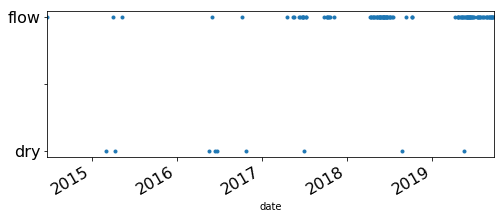

In [859]:
ax = data[data.mile==668.7].plot(x="date", y="status", style=".", figsize=(8,3), legend=False)
display(data[data.mile==668.7])
ax.set_yticklabels(["", "dry", "", "flow"]);